# Extract single model grid daily data(Basic variables)
* Since the data size is too large, please download the data from [OCDP](http://lamps.math.yorku.ca/OntarioClimate/index_app_data.htm#/DailyTmDataOnGrid)
* Or use this program download data to a temporal file then read it and covert to csv file
   - navigate to [grid data page](http://lamps.math.yorku.ca/OntarioClimate/index_app_data.htm#/DailyTmDataOnGrid)
   - copy link address(Download), for example: http://lamps.math.yorku.ca/OntarioClimate/DS_CMIP5/LAMPS_YorkU/Grids/Tas/RCP26/tas_LAMPS_NorESM1-M_RCP26_8964X365X119.mat
   - assign the address to variable matfile_url
* Plot spatial distribution map
* Plot daily, monthly and annual data at a grid, you can convert to csv file for further analysis
* Daily data includes four basic variables: **tas, tasmin, tasmax and pr**
---
*Programmer: Dr. Ziwang Deng, LAMPS, Department of Mathematics & Statistics, York University*

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon
from geopandas import GeoSeries
import scipy.io as sio
import datetime
import requests

## Download the file to local machine and then read it

In [37]:
# paste the copied link address here
varName='tas'
matfile_url = 'http://lamps.math.yorku.ca/OntarioClimate/DS_CMIP5/LAMPS_YorkU/Grids/Tas/RCP26/tas_LAMPS_NorESM1-M_RCP26_8964X365X119.mat'
# download the file to temp dirctory
totempfile = '../data/temp/tempfile.mat'
thefile = requests.get(matfile_url)
open(totempfile,'wb').write(thefile.content)

237887902

In [38]:
# read and map the variable for the period from 1979-2016
# user can download historical data from OCDP website: 
# http://lamps.math.yorku.ca/OntarioClimate/index_app_data.htm#/historicaldata

datacontent=sio.loadmat(totempfile)
# print(datacontent)
data = datacontent['outputData']/10.0   # the data in matfile is integer (real value *10), it must be divided by 10
print(np.shape(data))
# print(type(data))

(8964, 365, 119)


## plot the spatial distribution of the variable at a specific date

In [39]:
# We simplified the base four maps and saved them as geojson format, user can use other version base maps
# read basemap data in geojson files
lakefile='../shapefiles/Lake_Arc_simplify.geojson'
Municipal = '../shapefiles/Municipal_Arc_simplify.geojson'
Ontario = '../shapefiles/Ontario_arc.geojson'
OnPolygon = '../shapefiles/polygon9864.geojson'

# Ontario boundary
ont=gpd.read_file(Ontario)

# the lakes within Ontario
lake=gpd.read_file(lakefile)

# municipals
muni=gpd.read_file(Municipal)

# merge grid polygon and the data for plotting spatial variation map
cmp='jet'
poly=gpd.read_file(OnPolygon)

### Change the Year, Month, and Day here

(8964,)


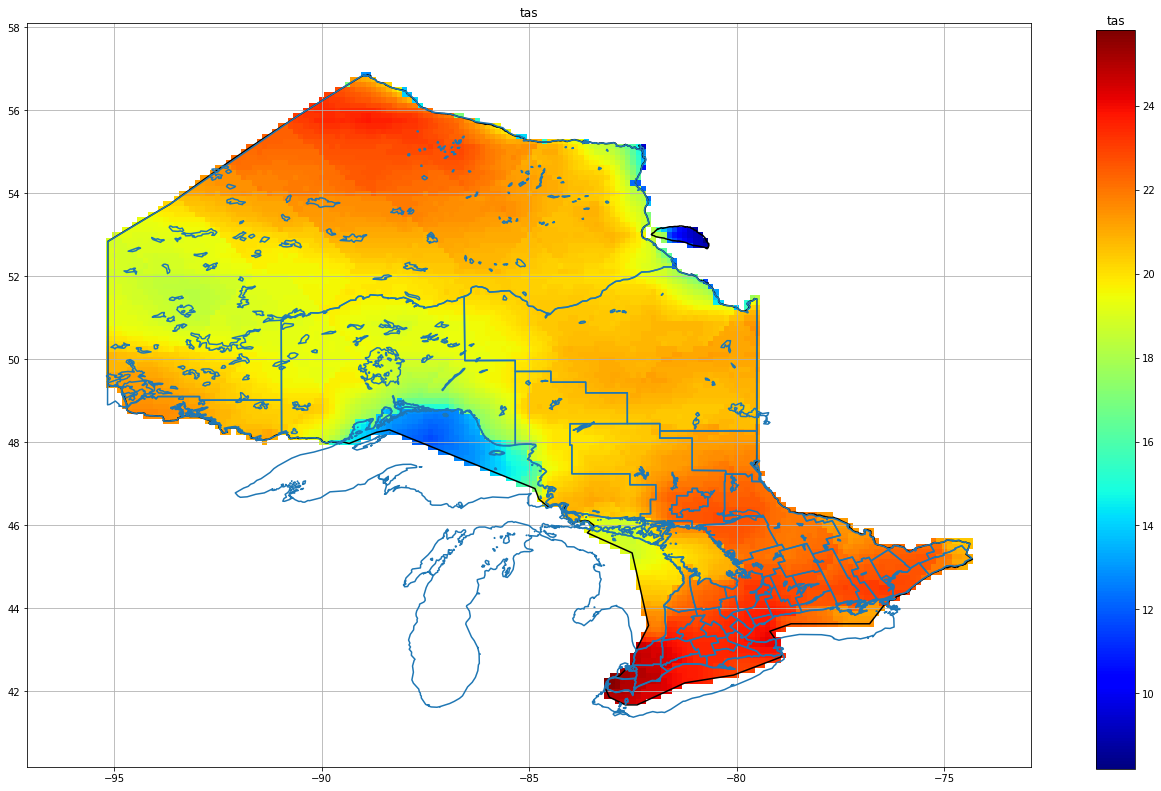

In [40]:
# display daily values on a map
# use can change this date (three values) to display weather map on different day
Year = 2016 # 1981-2099
Month = 7  # 1-12
Day = 28   # 

# extract the data on this specific day

theDate = datetime.date(Year,Month,Day)
# print(theDay)

theDayOfYear = theDate.timetuple().tm_yday
# print(theDayOfYear)

# our data does not include February 29 in leap year, so
if(is_leap_year(Year) and (theDayOfYear>59)):
    theDayOfYear=theDayOfYear-1
data_on_theDay = data[:,theDayOfYear-1,Year-1979]
print(np.shape(data_on_theDay))
data2map = pd.DataFrame(data_on_theDay,columns=['values'])
data2map['id']=pd.DataFrame(np.arange(1,8964))

# plot the background
p1=Polygon([(-96,41),(-74,41),(-74,57.3),(-96,57.3)])
g = GeoSeries(p1)
base=g.plot(color='white', edgecolor='white', figsize=(18,27))
ont.plot(ax=base, color='black', edgecolor='black')

# plot maps
lake.plot(ax=base)
muni.plot(ax=base)
polydata=poly.merge(data2map, on='id')
ax = polydata.plot(ax=base, column='values', colormap=cmp,vmin=min(polydata['values']),vmax=max(polydata['values']))

# setting legend
# thanks to: https://stackoverflow.com/questions/54236083/geopandas-reduce-legend-size-and-remove-white-space-below-map
ax.set_title(varName)
ax.grid() 
fig = ax.get_figure()
# here, need trial-and-error to get [l,b,w,h] right
# l:left, b:bottom, w:width, h:height; in normalized unit (0-1)

cbax = fig.add_axes([0.95, 0.31, 0.03, 0.38])   
cbax.set_title(varName)

sm = plt.cm.ScalarMappable(cmap=cmp,norm=plt.Normalize(vmin=min(polydata['values']), vmax=max(polydata['values'])))
sm._A = []
fig.colorbar(sm, cax=cbax, format="%d")
plt.show()



## plot time series at a location: change lon and lat.
   - the last line is for save data at a point to a csv file

(365, 119)
(10950, 7)


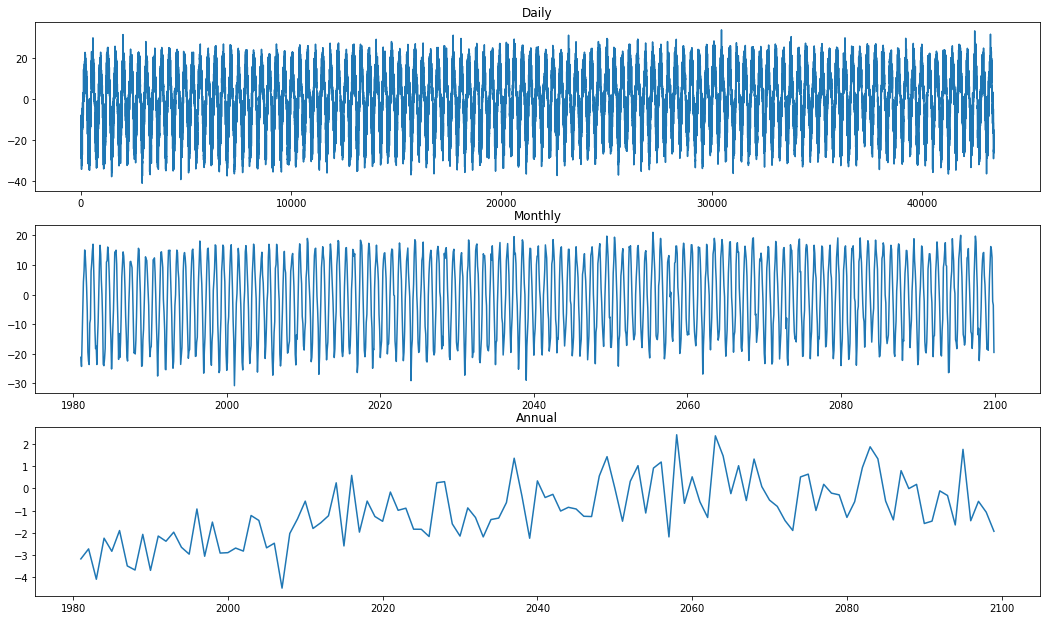

In [41]:
# following, we will plot time series at a specific location (latitude, longitude)
grids = pd.read_csv('../data/data/Historical/LAMPS_Ontario_8964Pts.csv')
# print(grids.columns)
lon=-84
lat=54
grids1=grids[abs(grids.Latitude-lat)<0.06251]
# print(grids1.columns)
grids2=grids1[abs(grids1.Longitude-lon)<0.06251]
if len(grids2) <1:
    print('sorry, your point is not in Ontario')
else:
    if len(grids2) ==1:
        timeseriesData= np.reshape(data[grids2.ID,:,:],(365,119))
        # print(np.shape(timeseriesData))
    else:
        tmp=data[grids2.ID,:,:]
        print(np.shape(tmp))
        timeseriesData=np.reshape(np.mean(tmp,axis=0),(365,119))
fig2 = plt.figure(figsize=(18,18))
ax1=plt.subplot(5,1,1)
plt.plot(timeseriesData.T.flatten())

# following we generate date range and calculate monthly mean, annuan mean
annualMean = np.mean(timeseriesData,axis=0)
Yrs = np.arange(119)+1981
ax3=plt.subplot(5,1,3)
plt.plot(Yrs,annualMean)
start=datetime.datetime.strptime('01-01-1981','%d-%m-%Y')
end = datetime.datetime.strptime('01-01-2100','%d-%m-%Y')
dates = [start + datetime.timedelta(days=x) for x in range(0,(end-start).days)]
# delete February 29
dates1 = [x for x in dates if not ((x.month == 2) and (x.day == 29))]
# print(np.shape(dates1))
df_data = pd.DataFrame(dates1,columns =['date'])
df_data['year'] = [x.year for x in dates1]
df_data['monthinyear'] = [x.month for x in dates1]
df_data['dayinmonth'] = [x.day for x in dates1]

df_data['weekinyear'] = [x.isocalendar()[1] for x in dates1]
df_data['dayinweek'] = [x.isocalendar()[2] for x in dates1]
print(np.shape(timeseriesData))
df_data['values'] = timeseriesData.T.flatten()
# print(df_data.head(40))



monthlyMean = df_data.groupby(['year','monthinyear'],as_index=False).agg({"values": "mean"})
# extract 30-yrs data 1981-2010
data30Yrs = df_data[df_data['year'] > 1980]

data30Yrs = data30Yrs[data30Yrs['year'] < 2011]                      
print(np.shape(data30Yrs))

# monthly30YrsMean = df_data.group
# print(monthlyMean.head(10)) 
ax2=plt.subplot(5,1,2)
plt.plot(monthlyMean.year+(monthlyMean.monthinyear-1)/12,monthlyMean['values']) 

ax1.title.set_text('Daily')
ax2.title.set_text('Monthly')
ax3.title.set_text('Annual')


# df_data.to_csv('replace with your path where you want to store the csv file/wantedcsvfilename.csv')